### 資料載入
使用下面的程式碼載入資料:



In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


設定雲端路徑

In [1]:
# path = 'drive/MyDrive/Colab Notebooks/photos'
path = 'photos/'

In [2]:
import matplotlib.pyplot as plt
from PIL import Image
import os
import glob
import random
import pandas as pd
import seaborn as sns
from torchvision import datasets ,models,transforms
from torch.utils import data
import torch.nn as nn
import torchvision
import numpy as np 
import torch
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import gc

c:\Users\rober\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Label =  blazer


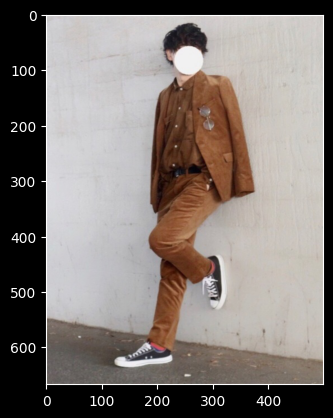

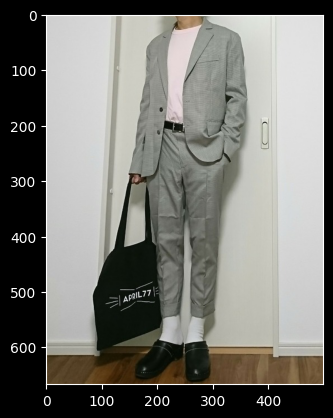

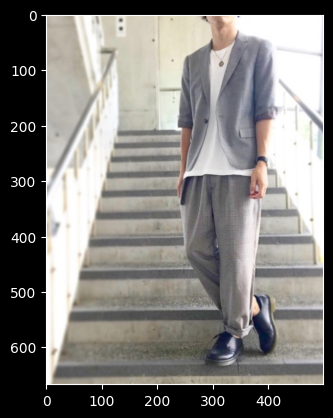

Label =  cardigan


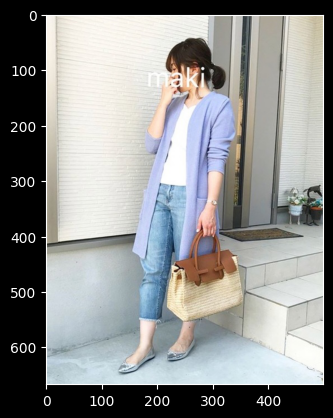

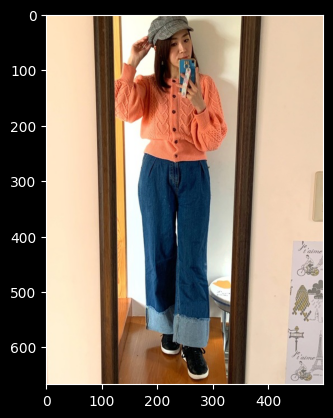

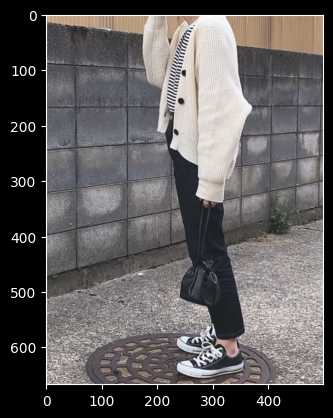

Label =  coat


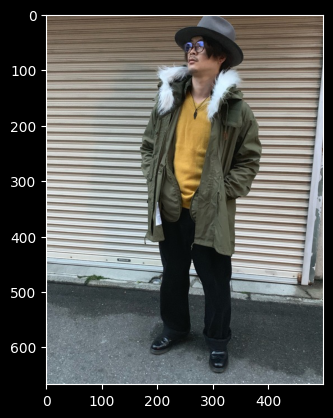

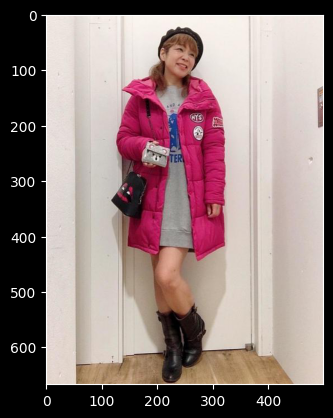

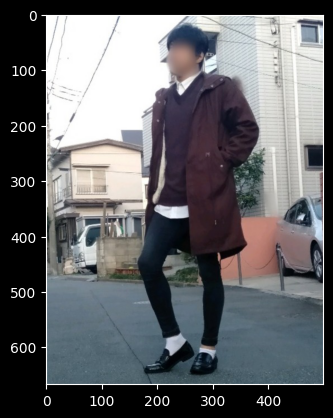

Label =  jacket


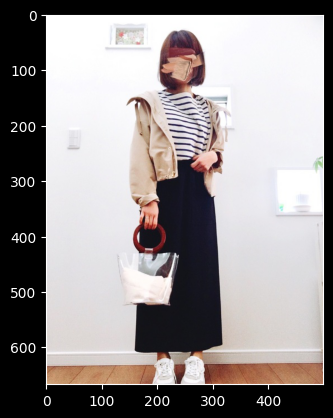

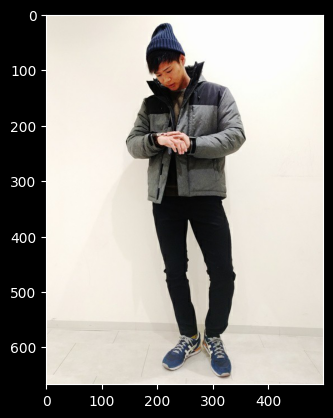

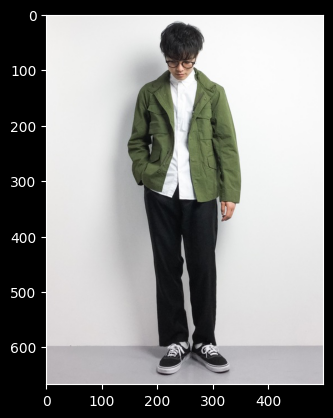

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
from PIL import Image
import os
import glob
import random

random.seed(1223)
labels = ['blazer', 'cardigan', 'coat', 'jacket']
for i in range(4):
    print("Label = ", labels[i])
    basepath = os.path.join(path,"train", labels[i], "*.jpg")
    cand_fn = glob.glob(basepath)
    for afn in random.choices(cand_fn, k = 3):    
        img = Image.open(afn)
        plt.imshow(img)
        plt.show()

# Q1 (5%) 
列出train, valid, test的總照片數，以及各類別的照片數與比率。在還沒進行模型訓練與評估前，你認為各類別相對的準確率的大小關係為何?

dataset = train,label = blazer : 97 photos
dataset = train,label = cardigan : 237 photos
dataset = train,label = coat : 296 photos
dataset = train,label = jacket : 411 photos
total train data : 1041 photos
dataset = valid,label = blazer : 7 photos
dataset = valid,label = cardigan : 36 photos
dataset = valid,label = coat : 27 photos
dataset = valid,label = jacket : 35 photos
total valid data : 105 photos
dataset = test,label = blazer : 9 photos
dataset = test,label = cardigan : 42 photos
dataset = test,label = coat : 43 photos
dataset = test,label = jacket : 52 photos
total test data : 146 photos


<AxesSubplot: xlabel='label', ylabel='count'>

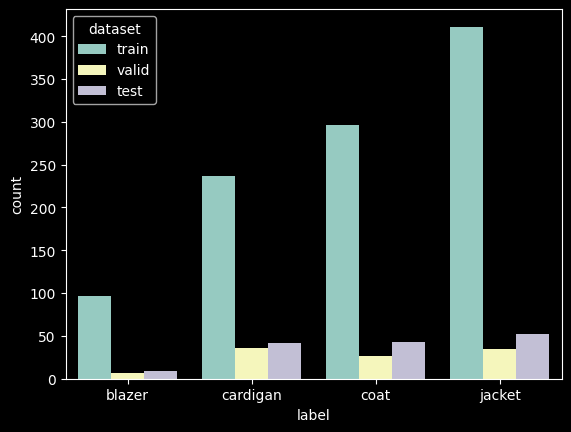

In [4]:
dirnames = ['train','valid','test']
total_df = pd.DataFrame([])
for dataset in dirnames :
    total_photos = 0
    for label in labels :
        basepath = os.path.join(path,dataset,label, "*.jpg")
        cand_fn = glob.glob(basepath)
        tmp_df = pd.DataFrame({'label':[label]*len(cand_fn),'dataset':[dataset]*len(cand_fn)})
        total_df = pd.concat([total_df,tmp_df],ignore_index=True)
        print(f'dataset = {dataset},label = {label} : {len(cand_fn)} photos')
        total_photos += len(cand_fn)
    print(f'total {dataset} data : {total_photos} photos')
    del tmp_df
sns.countplot(x='label',hue='dataset',data=total_df)

### Q1 小結
依據上述圖表jacket的資料筆數不管在哪個資料集都是最多的，因此推測預測結果jacket的準確率會最高，blazer因為資料筆數最少預測結果應該不會太好

# Q2 (35%)


### 調整圖片
由於圖片的解析度較高，模型訓練前須將解析度調整(Resize)成較短邊為256像素的照片，然後隨機取大小為224x224的影像。接著隨機水平翻轉(Horizontal Flip)、隨機旋轉-20度到20度，並依照Pretrained ResNet的要求調整RGB的均數與標準差。 測試資料(Valid and Test)亦須先將解析度調整(Resize)成較短邊為256像素的照片，然後取圖片中心224x224的影像。

In [ ]:
preprocess_train = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation((-20,20)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
preprocess_test = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
subtrain_set = datasets.DatasetFolder(os.path.join(path,"train"), loader=lambda x: Image.open(x), extensions="jpg", transform=preprocess_train)
valid_set = datasets.DatasetFolder(os.path.join(path,"valid"), loader=lambda x: Image.open(x), extensions="jpg", transform=preprocess_test)
test_set = datasets.DatasetFolder(os.path.join(path,"test"), loader=lambda x: Image.open(x), extensions="jpg", transform=preprocess_test)

subtrain_loader = data.DataLoader(subtrain_set, batch_size=32, shuffle=True)
valid_loader = data.DataLoader(valid_set, batch_size=32, shuffle=False)
test_loader = data.DataLoader(test_set, batch_size=32, shuffle=False)
        
print("Get length:", len(subtrain_set))    
print(subtrain_set[0][0].shape)
del subtrain_set,valid_set,test_set      

Get length: 1041
torch.Size([3, 224, 224])


### 設定模型
使用torchvision提供的pretrained weights (torchvision.models.resnet50(pretrained=True))初始化模型權重。使用train資料訓練模型，以valid資料決定Early Stopping的Epoch。Early Stopping的Patient參數設為20 Epochs。Batch size設為32。每一個Epoch計算一次Valid Loss，並記錄Valid Loss最低的模型。模型訓練最多200個Epochs。使用最佳模型在test資料計算模型Accuracy, Confusion Matrix, 與Per-class Accuracy。你應該要考慮SGD與ADAM兩種最佳化演算法。調整超參數以達到最好的Valid Loss。

In [ ]:
class Resnet50(nn.Module):
    def __init__(self,pretrain=True):
        super(Resnet50,self).__init__()
        self.patience = 20
        self.epoch = 200
        self.model = torchvision.models.resnet50(pretrained=pretrain)
        self.loss = nn.CrossEntropyLoss()
        self.train_loss_lst = []
        self.valid_loss_lst = []
        self.best_loss = np.inf
        self.best_model = None
        

    def calc_loss(self,device,loader):
       self.model.eval()
       total_loss = 0
       with torch.no_grad():
           for batch_idx, (inputs, targets) in enumerate(loader):
               inputs, targets = inputs.to(device), targets.to(device)
               outputs = self.model(inputs)        
               loss= self.loss(outputs, targets)      
               total_loss += loss
           loss_result = (total_loss/len(loader))
       self.model.train()
       return loss_result
    

    def train(self,device,optimizer,verbose=True):
        for epoch_idx in range(1,self.epoch+1):
            total_loss = 0
            for batch_idx, (inputs, targets) in enumerate(subtrain_loader):
                self.model.train()
                inputs, targets = inputs.to(device), targets.to(device)
                self.model = self.model.to(device)
                optimizer.zero_grad()
                self.model = self.model.float()
                outputs = self.model(inputs)
                loss = self.loss(outputs, targets) 
                loss.backward()
                optimizer.step()
                total_loss += loss
            gc.collect()    
            loss_train = (total_loss/len(subtrain_loader)).cpu().detach().numpy()
            self.train_loss_lst.append(loss_train)
            loss_valid = self.calc_loss(device,valid_loader).cpu().detach().numpy()
            self.valid_loss_lst.append(loss_valid)
            if verbose:
                print(f'Epoch:{epoch_idx}')
                print(f'Training Loss:{loss_train}')
                print(f'Validation Loss:{loss_valid}')
            if loss_valid < self.best_loss:
                self.best_loss = loss_valid
                self.best_epoch = epoch_idx
                self.best_model = self.model 
            elif epoch_idx - self.best_epoch > self.patience:
                self.end_epoch = epoch_idx
                print('============Early Stop==================')
                print(f'best step:{self.best_epoch} best loss:{self.best_loss}')
                return self.best_model  
        self.end_epoch = epoch_idx
        torch.save(self.best_model,'drive/MyDrive/Colab Notebooks/hw5_bestmodel.pkl')
           
    
    def test(self,device,loader):
        self.best_model.eval()
        targets_list=[]
        preds_list=[]
        with torch.no_grad():
            for inputs, targets in loader:
              inputs, targets = inputs.to(device), targets.to(device)
              outputs = self.best_model(inputs)
              _, preds = torch.max(outputs, dim=1)
              targets_list.extend(targets.cpu().detach().numpy())
              preds_list.extend(preds.cpu().detach().numpy())
            acc = accuracy_score(targets_list, preds_list)
            mat = confusion_matrix(targets_list, preds_list)
            sns.heatmap(mat,annot=True, cbar=False, cmap=plt.cm.Blues,xticklabels=labels,yticklabels=labels)
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.show()       
        print(f'Test Accuracy: {acc*100}%')
        print('=======================Individual Accuracy===========================')
        for i, acc in enumerate(mat):
          print(f'{labels[i]}: {(mat[i][i]/sum(mat[i]))*100}%')


    def plot(self):
      plt.figure(figsize=(10,8))
      plt.plot(self.train_loss_lst, label='subtrain')
      plt.plot(self.valid_loss_lst, label='valid')
      plt.title(f'Train & Valid historical loss')
      plt.xlabel('epoches')
      plt.ylabel('CrossEntropyLoss')
      plt.legend(loc='best')
      plt.show()

### SGD
將最後一層的Fully Connected Layer輸出維度改成4以符合本題任務需求

Epoch:1
Training Loss:1.3082051277160645
Validation Loss:1.2417001724243164
Epoch:2
Training Loss:1.2638347148895264
Validation Loss:1.2145006656646729
Epoch:3
Training Loss:1.2438292503356934
Validation Loss:1.2028340101242065
Epoch:4
Training Loss:1.226870059967041
Validation Loss:1.1932752132415771
Epoch:5
Training Loss:1.2141852378845215
Validation Loss:1.1721088886260986
Epoch:6
Training Loss:1.1899789571762085
Validation Loss:1.1689262390136719
Epoch:7
Training Loss:1.177695393562317
Validation Loss:1.157376766204834
Epoch:8
Training Loss:1.1627953052520752
Validation Loss:1.138006329536438
Epoch:9
Training Loss:1.136504054069519
Validation Loss:1.1221239566802979
Epoch:10
Training Loss:1.131482481956482
Validation Loss:1.1239182949066162
Epoch:11
Training Loss:1.1122537851333618
Validation Loss:1.0977593660354614
Epoch:12
Training Loss:1.0972497463226318
Validation Loss:1.0890756845474243
Epoch:13
Training Loss:1.0812840461730957
Validation Loss:1.0870054960250854
Epoch:14
Train

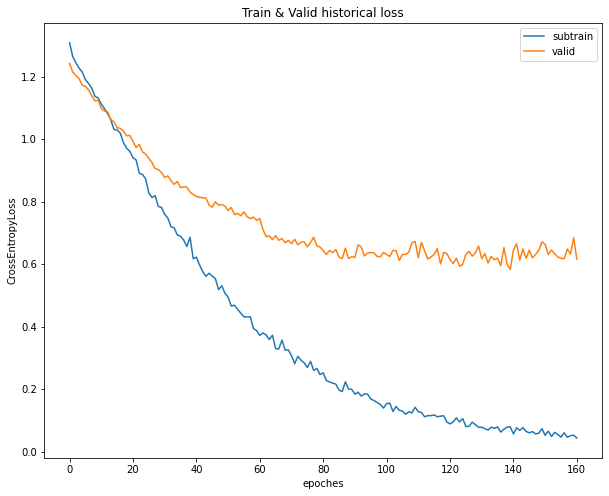

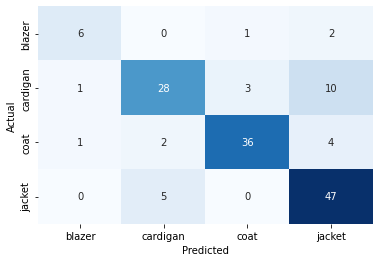

Test Accuracy: 80.13698630136986%
=======================Individual Accuracy===========================
blazer: 66.66666666666666%
cardigan: 66.66666666666666%
coat: 83.72093023255815%
jacket: 90.38461538461539%


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
resnet50 = Resnet50()
resnet50.model.fc = nn.Linear(2048,4)
optimizer = torch.optim.SGD(resnet50.model.parameters(), lr = 0.0001,momentum=0.9)
resnet50.train(device, optimizer)
resnet50.plot()
resnet50.test(device, test_loader)

### Adam
將最後一層的Fully Connected Layer輸出維度改成4以符合本題任務需求

Epoch:1
Training Loss:1.3216232061386108
Validation Loss:1.207747459411621
Epoch:2
Training Loss:1.1856322288513184
Validation Loss:1.106259822845459
Epoch:3
Training Loss:1.0888140201568604
Validation Loss:1.03444242477417
Epoch:4
Training Loss:0.9686654806137085
Validation Loss:0.974437415599823
Epoch:5
Training Loss:0.871131420135498
Validation Loss:0.9104862213134766
Epoch:6
Training Loss:0.7625142931938171
Validation Loss:0.8470855355262756
Epoch:7
Training Loss:0.6984260678291321
Validation Loss:0.7841692566871643
Epoch:8
Training Loss:0.6164600849151611
Validation Loss:0.756485104560852
Epoch:9
Training Loss:0.5556346774101257
Validation Loss:0.7259898781776428
Epoch:10
Training Loss:0.499324768781662
Validation Loss:0.7002782821655273
Epoch:11
Training Loss:0.4432852268218994
Validation Loss:0.6467234492301941
Epoch:12
Training Loss:0.38356417417526245
Validation Loss:0.6406855583190918
Epoch:13
Training Loss:0.33623555302619934
Validation Loss:0.5858862996101379
Epoch:14
Train

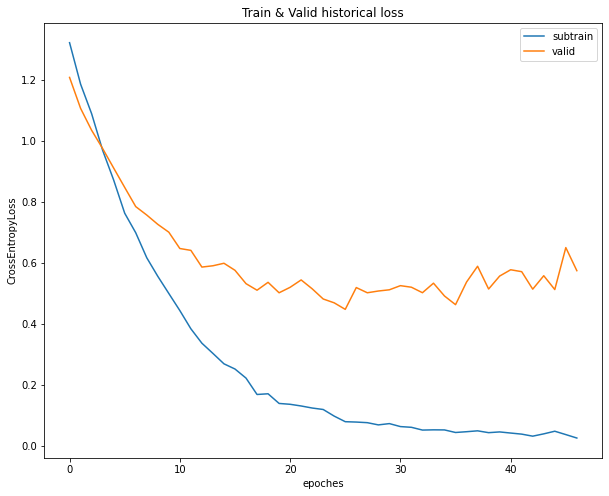

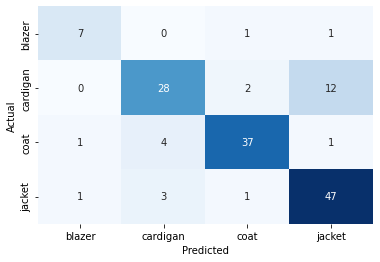

Test Accuracy: 81.5068493150685%
=======================Individual Accuracy===========================
blazer: 77.77777777777779%
cardigan: 66.66666666666666%
coat: 86.04651162790698%
jacket: 90.38461538461539%


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
resnet50 = Resnet50()
resnet50.model.fc = nn.Linear(2048,4)
optimizer = torch.optim.Adam(resnet50.model.parameters(), lr = 0.00001)
resnet50.train(device, optimizer)
resnet50.plot()
resnet50.test(device, test_loader)

### Q2小結
如同Q1所預測jacket的準確率是最高的，而blazer跟cardigan因為資料筆數沒那麼多準確率相較就比較差，模型在收斂上Adam比SGD快不少，但兩者都明顯出現overfitting的狀況。

# Q3 (30%) 
與第二題幾乎相同，唯一不同是此題訓練時固定除了最後一層以外的其他權重，只調整最後一層Fully Connected Layer。


### SGD

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Epoch:1
Training Loss:1.3625421524047852
Validation Loss:1.2674362659454346
Epoch:2
Training Loss:1.300681710243225
Validation Loss:1.2623605728149414
Epoch:3
Training Loss:1.281951904296875
Validation Loss:1.2446796894073486
Epoch:4
Training Loss:1.2716330289840698
Validation Loss:1.2265129089355469
Epoch:5
Training Loss:1.2544734477996826
Validation Loss:1.219189167022705
Epoch:6
Training Loss:1.2469948530197144
Validation Loss:1.2036499977111816
Epoch:7
Training Loss:1.2385644912719727
Validation Loss:1.1974748373031616
Epoch:8
Training Loss:1.2249444723129272
Validation Loss:1.1886650323867798
Epoch:9
Training Loss:1.2131401300430298
Validation Loss:1.1744838953018188
Epoch:10
Training Loss:1.2137703895568848
Validation Loss:1.1827735900878906
Epoch:11
Training Loss:1.199126958847046
Validation Loss:1.165863275527954
Epoch:12
Training Loss:1.1826893091201782
Validation Loss:1.1568477153778076
Epoch:13
Training Loss:1.1787209510803223
Validation Loss:1.1552051305770874
Epoch:14
Trai

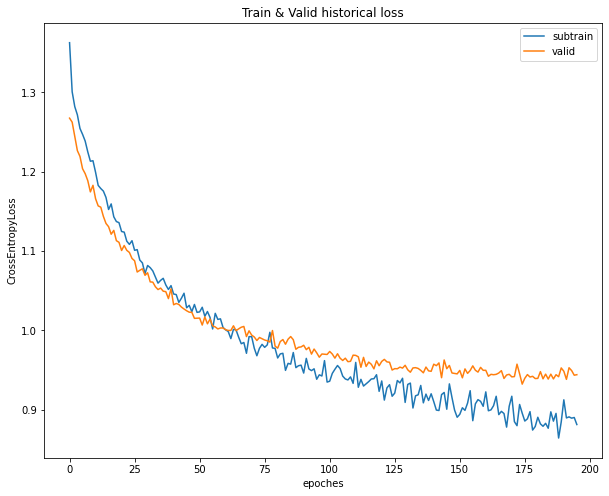

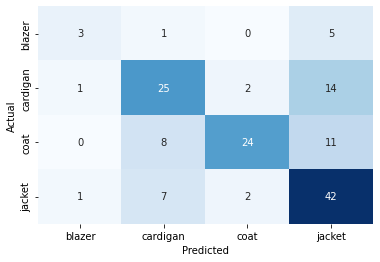

Test Accuracy: 64.38356164383562%
=======================Individual Accuracy===========================
blazer: 33.33333333333333%
cardigan: 59.523809523809526%
coat: 55.81395348837209%
jacket: 80.76923076923077%


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
resnet50 = Resnet50()
##模型訓練時固定除了最後一層以外的其他權重，訓練時只會調整最後一層Fully Connected Layer。
for param in resnet50.model.parameters():
  param.requires_grad = False
resnet50.model.fc = nn.Linear(2048,4)
optimizer = torch.optim.SGD(resnet50.model.parameters(), lr = 0.0001,momentum=0.9)
resnet50.train(device, optimizer)
resnet50.plot()
resnet50.test(device, test_loader)

### Adam

Epoch:1
Training Loss:1.4221932888031006
Validation Loss:1.401350498199463
Epoch:2
Training Loss:1.3466148376464844
Validation Loss:1.3237271308898926
Epoch:3
Training Loss:1.315118670463562
Validation Loss:1.2839679718017578
Epoch:4
Training Loss:1.3016523122787476
Validation Loss:1.262413501739502
Epoch:5
Training Loss:1.2857965230941772
Validation Loss:1.2480593919754028
Epoch:6
Training Loss:1.2850780487060547
Validation Loss:1.2415562868118286
Epoch:7
Training Loss:1.28779137134552
Validation Loss:1.2356152534484863
Epoch:8
Training Loss:1.279407024383545
Validation Loss:1.2307727336883545
Epoch:9
Training Loss:1.274437427520752
Validation Loss:1.2269482612609863
Epoch:10
Training Loss:1.269100546836853
Validation Loss:1.2197816371917725
Epoch:11
Training Loss:1.2721220254898071
Validation Loss:1.21632719039917
Epoch:12
Training Loss:1.2721736431121826
Validation Loss:1.2152382135391235
Epoch:13
Training Loss:1.2668803930282593
Validation Loss:1.2136518955230713
Epoch:14
Training 

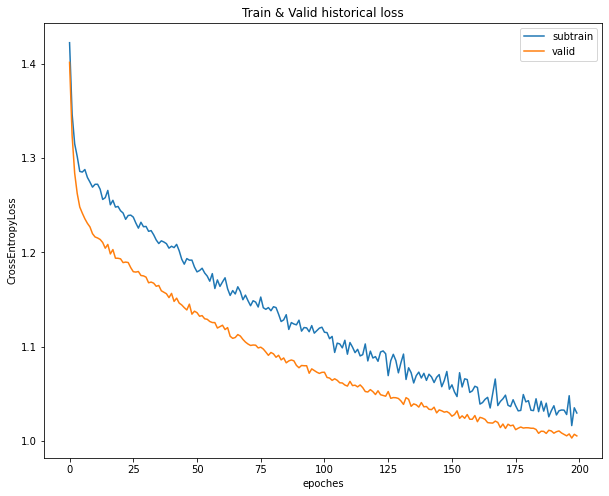

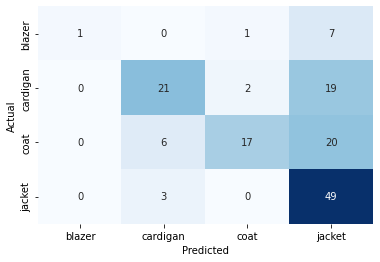

Test Accuracy: 60.273972602739725%
=======================Individual Accuracy===========================
blazer: 11.11111111111111%
cardigan: 50.0%
coat: 39.53488372093023%
jacket: 94.23076923076923%


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
resnet50 = Resnet50()
##模型訓練時固定除了最後一層以外的其他權重，訓練時只會調整最後一層Fully Connected Layer。
for param in resnet50.model.parameters():
  param.requires_grad = False
resnet50.model.fc = nn.Linear(2048,4)
optimizer = torch.optim.Adam(resnet50.model.parameters(), lr = 0.00001)
resnet50.train(device, optimizer)
resnet50.plot()
resnet50.test(device, test_loader)

### Q3 小結
與第二題相比train_loss和valid_loss訓練時相差沒那麼遠，jacket仍是準確率最高的項目，兩者的收斂情況不是很好幾乎要跑完所有的epoches，與第二題不同的是SGD在只調整最後一層Fully Connected Layer表現得比Adam更好

# Q4(20%)
不使用預訓練權重初始化模型。使用train訓練模型。

### SGD

Epoch:1
Training Loss:1.3621710538864136
Validation Loss:1.264646291732788
Epoch:2
Training Loss:1.3062785863876343
Validation Loss:1.2831230163574219
Epoch:3
Training Loss:1.3089767694473267
Validation Loss:1.2717448472976685
Epoch:4
Training Loss:1.2930705547332764
Validation Loss:1.259592890739441
Epoch:5
Training Loss:1.3003034591674805
Validation Loss:1.2310230731964111
Epoch:6
Training Loss:1.2924288511276245
Validation Loss:1.2498505115509033
Epoch:7
Training Loss:1.2878494262695312
Validation Loss:1.295865774154663
Epoch:8
Training Loss:1.2940829992294312
Validation Loss:1.248798131942749
Epoch:9
Training Loss:1.2882380485534668
Validation Loss:1.3014140129089355
Epoch:10
Training Loss:1.289609432220459
Validation Loss:1.2983827590942383
Epoch:11
Training Loss:1.2854753732681274
Validation Loss:1.2888132333755493
Epoch:12
Training Loss:1.2808727025985718
Validation Loss:1.313463807106018
Epoch:13
Training Loss:1.2911213636398315
Validation Loss:1.2648788690567017
Epoch:14
Train

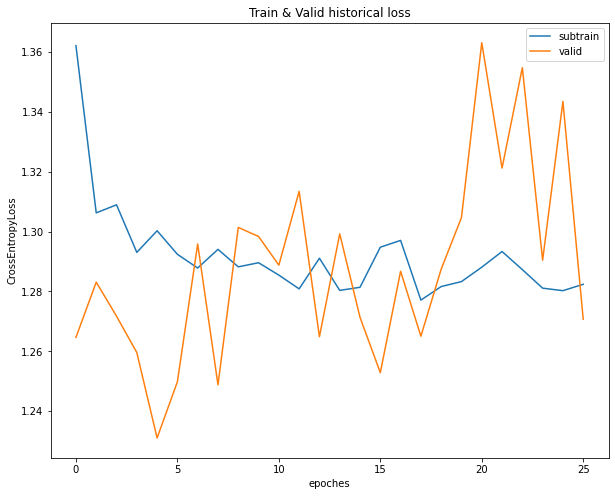

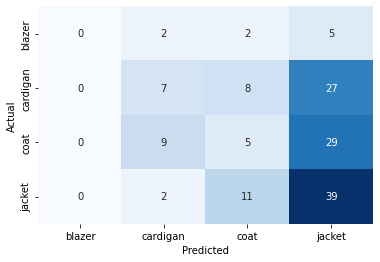

Test Accuracy: 34.93150684931507%
=======================Individual Accuracy===========================
blazer: 0.0%
cardigan: 16.666666666666664%
coat: 11.627906976744185%
jacket: 75.0%


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
resnet50 = Resnet50(pretrain=False)
resnet50.model.fc = nn.Linear(2048,4)
optimizer = torch.optim.SGD(resnet50.model.parameters(), lr = 0.0001,momentum=0.9)
resnet50.train(device, optimizer)
resnet50.plot()
resnet50.test(device, test_loader)

### Adam

Epoch:1
Training Loss:1.4582573175430298
Validation Loss:1.5607247352600098
Epoch:2
Training Loss:1.3029381036758423
Validation Loss:1.2957468032836914
Epoch:3
Training Loss:1.2806462049484253
Validation Loss:1.249794363975525
Epoch:4
Training Loss:1.2755310535430908
Validation Loss:1.2867841720581055
Epoch:5
Training Loss:1.274414300918579
Validation Loss:1.2551212310791016
Epoch:6
Training Loss:1.2643924951553345
Validation Loss:1.2682832479476929
Epoch:7
Training Loss:1.2628560066223145
Validation Loss:1.2664347887039185
Epoch:8
Training Loss:1.2651150226593018
Validation Loss:1.2463124990463257
Epoch:9
Training Loss:1.2577342987060547
Validation Loss:1.2834043502807617
Epoch:10
Training Loss:1.2635712623596191
Validation Loss:1.3085309267044067
Epoch:11
Training Loss:1.2593164443969727
Validation Loss:1.2672233581542969
Epoch:12
Training Loss:1.2514351606369019
Validation Loss:1.3001887798309326
Epoch:13
Training Loss:1.2572098970413208
Validation Loss:1.2741950750350952
Epoch:14
T

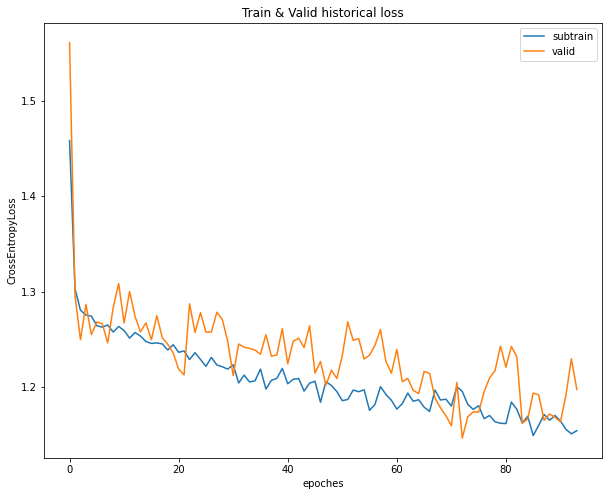

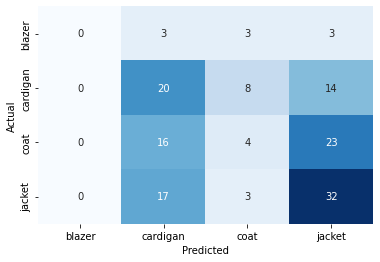

Test Accuracy: 38.35616438356164%
=======================Individual Accuracy===========================
blazer: 0.0%
cardigan: 47.61904761904761%
coat: 9.30232558139535%
jacket: 61.53846153846154%


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
resnet50 = Resnet50(pretrain=False)
resnet50.model.fc = nn.Linear(2048,4)
optimizer = torch.optim.Adam(resnet50.model.parameters(), lr = 0.00001)
resnet50.train(device, optimizer)
resnet50.plot()
resnet50.test(device, test_loader)

### Q4小結
與pretrained model相比很明顯準確率下降很多，甚至blazer預測完全錯誤，推測原因可能是資料筆數不夠多使用pretrain model會是比較好的選擇，在收斂速度方面Adam明顯比SGD更慢。

# Q5(10%)
統整併討論Q2-Q4的預測能力。說明你的觀察

| Setting | SGD | ADAM |
|------------|---------------------|--------------------|
|Pretrained           |  80.13%  | 81.5%   |
|Pretrained + Freeze Layers | 64.38%   | 60.27% | 
|No Pretrained         | 34.93%   | 38.35% |

從model的比較基準上pretrain比no pretrain出色太多，推測原因可能是資料筆數不夠多使用pretrain model會是比較好的選擇，而在使用pretrain model之下可調整所有layers參數比只能調整final layers準確率更高，另外若以選用optimizer作為比較基準，收斂速度會是兩者比較大的差別，以上例子SGD收斂速度都比Adam更快，但犧牲的可能是準確率較低。